In [0]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit as sigmoid

#### Handwritten Digit classification using the entire MNIST Dataset from http://yann.lecun.com/exdb/mnist/  
* The training and the test set consist of 60,000 and 10,000 samples respectively. Each sample is a 28x28 pixel image.  

* The data in the files were parsed using [**python-mnist**](https://github.com/sorki/python-mnist)  
* There was no preprocessing attempted on the data   
* The classification was implemented using a 3 layer neural network with 784 input units, 300 hidden units and 10 output units.  
* Due to the enormous processing requirements, this notebook had to be implemented in [Google Colaboratory](https://colab.research.google.com).  
* Classification accuracy obtained on the test set: **94.58 %**
* Even with 300 units in the hidden layer the network is still suffering from bias


In [0]:
# Load training data stored in MNIST Format
mndata = MNIST()
mndata.gz = True
images,labels = mndata.load_training()

In [89]:
y = np.array(labels)
m = y.size
X = np.array(images)
X.shape

(60000, 784)

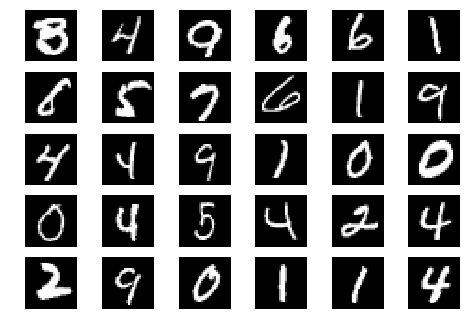

In [90]:
# Plotting 30 random examples from X
indices = np.random.randint(0,m,30)

fig = plt.figure()
for i in range (30):
    img = X[indices[i]].reshape(28,28)
    fig.add_subplot(5,6,i+1)
    plt.imshow(img,cmap='gray')
    plt.axis("off")

plt.show()

In [91]:
# Neural Network Parameters
ip_size = 784 
hidden_size = 300
num_labels = np.unique(y).size
num_labels

10

In [0]:
# Sigmoid Gradient function
def sigmoid_grad(x):
    g = sigmoid(x)
    return (g*(1-g))
    

In [0]:
# Cost Function and Gradients
# Feedforward the neural network and return the cost in variable J

def costFunction(nn_params,i_size,h_size,labels,X,y,lamb):
    m = X.shape[0]
    # Reshaping the Parameters
    Theta1 = nn_params[:h_size*(i_size +1)].reshape(h_size,i_size+1)
    Theta2 = nn_params[h_size*(i_size +1):].reshape(labels,h_size+1)
    # For training a NN we recode the labels as vectors containing
    # only 0 or 1 values
    eye_mat = np.eye(labels)
    y_mat = eye_mat[:,y]
    
    # Forward Propagation
    X = np.c_[np.ones(m),X]
    z2 = X.dot(Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones(m),a2]
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    h = a3.T
    
    # Calculating the cost
    J = (-1.0/m)*np.sum(y_mat*np.log(h) + (1-y_mat)*np.log(1-h))
    # Adding Regularization Term (Not considering terms that correspond to bias)
    J = J + (lamb/(2.0*m)) * (np.sum(Theta1[:,1:]**2)+ np.sum(Theta2[:,1:]**2))
    
    # Backpropagation
    delta3 = h-y_mat
    delta2 = ((Theta2[:,1:].T).dot(delta3)) * sigmoid_grad(z2.T)
    Acc_D2 = delta3.dot(a2)
    Acc_D1 = delta2.dot(X)
    
    # Gradients
    Theta2_grad = (1.0/m) * Acc_D2 
    Theta1_grad = (1.0/m) * Acc_D1
    # Adding Regularization Term (Not considering terms that correspond to bias)
    reg_term2 = np.c_[np.zeros(Theta2.shape[0]),Theta2[:,1:]]
    Theta2_grad = Theta2_grad + (lamb/float(m)) * reg_term2
    
    reg_term1 = np.c_[np.zeros(Theta1.shape[0]),Theta1[:,1:]]
    Theta1_grad = Theta1_grad + (lamb/float(m)) * reg_term1
    
    # Unrolling the gradients into a vector
    grad = np.append(Theta1_grad,Theta2_grad)
    
    return J,grad

In [94]:
# Random Intialization of weights for symmetry breaking
e_init = np.sqrt(6)/np.sqrt(ip_size + num_labels)
e_init = round(e_init,3)
T1 = np.random.rand(hidden_size,ip_size+1) * 2*e_init-e_init
T2 = np.random.rand(num_labels,hidden_size+1) * 2*e_init-e_init
init_params = np.append(T1,T2)  
T1.shape,T2.shape

((300, 785), (10, 301))

In [95]:
# Cost and Grad with init_params and lambda = 0
J,G = costFunction(init_params,ip_size,hidden_size,num_labels,X,y,0)
print J
print G

6.9083920867757955
[-1.90491029e-04  0.00000000e+00  0.00000000e+00 ...  2.08676256e-01
  4.91292336e-01  4.15096166e-01]


In [96]:
# Cost and Grad with init_params and lambda = 1
J,G = costFunction(init_params,ip_size,hidden_size,num_labels,X,y,1)
print J
print G

6.913393940741709
[-1.90491029e-04 -8.40849602e-07  1.03141179e-06 ...  2.08675309e-01
  4.91291387e-01  4.15096588e-01]


In [0]:
# Computing Gradient using Numerical Computation
def numgrad(theta,args):
    m = theta.size
    epsilon = 1e-4
    numgrad = np.zeros(m)
    perturb = np.zeros(m)
    for i in range(m):
        perturb[i] = epsilon
        loss1 = costFunction((theta-perturb),*args)[0] 
        loss2 = costFunction((theta+perturb),*args)[0]
        numgrad[i] = (loss2-loss1)/(2*epsilon);
        perturb[i]=0
    return numgrad

In [0]:
# Initialize the weights of a layer with fan_in incoming connections and fan_out outgoing connections
# using a fixed strategy, this will help in debugging
def debugInitialWeights(fan_out,fan_in):
    W = np.zeros((fan_out,fan_in +1))
    W =(np.sin(np.arange(1,W.size+1))/10).reshape(W.shape)
    return W  

In [0]:
# checkNNGradients  Creates a small neural network to check the backpropagation gradients
# It will output the analytical gradients produced by your backprop code and the numerical gradients 
# (computed using numgrad). These two gradient computations should result in very similar values
def checkNNGradients(lamb):
    i_size = 3; h_size = 3 ;num_labels = 3; m = 5
    # Generating random data
    Theta1 = debugInitialWeights(h_size,i_size)
    Theta2 = debugInitialWeights(num_labels,h_size)
    X = debugInitialWeights(m,i_size-1)
    y = np.mod(np.arange(m),num_labels)
    # Unroll parameters
    nn_params = np.append(Theta1,Theta2)
    
    args = i_size,h_size,num_labels,X,y,lamb
    G1 = costFunction(nn_params,*args)[1]
    G2 = numgrad(nn_params,args)
    print "The two columns below should be very similar"
    print "(Left-Backprop Gradients, Right-Numerical Gradient)"
    print np.c_[G1[:,np.newaxis],G2[:,np.newaxis]]
    print "The difference is less than 1e-9: %s" % np.allclose(G1,G2,rtol=1e-9,atol=1e-9)
    

In [100]:
# Checking Backprop w/o Regularization
checkNNGradients(lamb = 0)

The two columns below should be very similar
(Left-Backprop Gradients, Right-Numerical Gradient)
[[-1.67407607e-03 -1.67407607e-03]
 [ 2.01559293e-05  2.01559280e-05]
 [ 3.49877111e-04  3.49877107e-04]
 [ 3.57922891e-04  3.57922894e-04]
 [-5.13333018e-03 -5.13333017e-03]
 [ 3.90290328e-04  3.90290325e-04]
 [ 4.49087678e-04  4.49087676e-04]
 [ 9.49958883e-05  9.49958867e-05]
 [-3.88117379e-03 -3.88117379e-03]
 [ 4.02480309e-04  4.02480309e-04]
 [ 1.36027964e-04  1.36027964e-04]
 [-2.55487864e-04 -2.55487866e-04]
 [ 1.24904785e-01  1.24904785e-01]
 [ 6.49053029e-02  6.49053029e-02]
 [ 5.99422224e-02  5.99422224e-02]
 [ 6.32813548e-02  6.32813547e-02]
 [ 9.28155988e-02  9.28155988e-02]
 [ 4.87480585e-02  4.87480585e-02]
 [ 4.41460450e-02  4.41460450e-02]
 [ 4.70247564e-02  4.70247564e-02]
 [ 2.84472304e-01  2.84472304e-01]
 [ 1.48101428e-01  1.48101428e-01]
 [ 1.35184382e-01  1.35184382e-01]
 [ 1.45593145e-01  1.45593145e-01]]
The difference is less than 1e-9: True


In [101]:
# Checking Backprop with Regularization
checkNNGradients(lamb = 2)

The two columns below should be very similar
(Left-Backprop Gradients, Right-Numerical Gradient)
[[-0.00167408 -0.00167408]
 [ 0.03639205  0.03639205]
 [ 0.00599468  0.00599468]
 [-0.02991418 -0.02991418]
 [-0.00513333 -0.00513333]
 [-0.01078633 -0.01078633]
 [ 0.02672855  0.02672855]
 [ 0.03966933  0.03966933]
 [-0.00388117 -0.00388117]
 [-0.02135836 -0.02135836]
 [-0.03986358 -0.03986358]
 [-0.0217184  -0.0217184 ]
 [ 0.12490479  0.12490479]
 [ 0.1012772   0.1012772 ]
 [ 0.06558702  0.06558702]
 [ 0.03300925  0.03300925]
 [ 0.0928156   0.0928156 ]
 [ 0.03757144  0.03757144]
 [ 0.07042551  0.07042551]
 [ 0.08659909  0.08659909]
 [ 0.2844723   0.2844723 ]
 [ 0.12634058  0.12634058]
 [ 0.09518477  0.09518477]
 [ 0.12413023  0.12413023]]
The difference is less than 1e-9: True


In [0]:
# Optimizing the parameters theta using scipy.optimize 
def find_min(init_theta,par):
    res = minimize(costFunction,init_theta,args=(par),method = 'CG',jac = True
               ,options={'maxiter':200,'disp':True})  
    return res.x


In [103]:
%%time
# Training the NN
lamb = 0
par = ip_size,hidden_size,num_labels,X,y,lamb
final_params = find_min(init_params,par)

         Current function value: 0.241118
         Iterations: 200
         Function evaluations: 256
         Gradient evaluations: 256
CPU times: user 26min 12s, sys: 1min 46s, total: 27min 58s
Wall time: 15min 49s


In [0]:
# Obtaining Theta1_final and Theta2_final from final_params
Theta1_final = final_params[:hidden_size*(ip_size +1)].reshape(hidden_size,ip_size+1)
Theta2_final = final_params[hidden_size*(ip_size +1):].reshape(num_labels,hidden_size+1)

In [0]:
# Load testing data stored in MNIST Format
mndata2 = MNIST()
mndata2.gz = True
images_test,labels_test = mndata2.load_testing()

In [106]:
y_test = np.array(labels_test)
m_test = y_test.size
X_test = np.array(images_test)
X_test.shape

(10000, 784)

In [0]:
# Predict the labels
def predict(Theta1,Theta2,X):
    m = X.shape[0]
    X = np.c_[np.ones(m),X]
    z2 = X.dot(Theta1.T)
    a2 = sigmoid(np.c_[np.ones(m),z2])
    z3 = a2.dot(Theta2.T)
    h = sigmoid(z3)
    p = np.argmax(h,1)
    return p 

In [108]:
# Getting Accuracy on the Test Set
y_pred = predict(Theta1_final,Theta2_final,X_test)
accuracy = np.mean(y_pred == y_test)*100
print "Accuracy on the Test Set %s %%" % round(accuracy,3)
print "NN made errors in predicting %s samples out of 10000 in the testing set " % np.count_nonzero(y_test != y_pred)

Accuracy on the Test Set 94.58 %
NN made errors in predicting 542 samples out of 10000 in the testing set 


In [109]:
# Getting Accuracy on the Training Set
y_pred2 = predict(Theta1_final,Theta2_final,X)
accuracy2 = np.mean(y_pred2 == y)*100
print "Accuracy on the Training Set %s %%" % round(accuracy2,3)
print "NN made errors in predicting %s samples out of 60000 in the training set " % np.count_nonzero(y != y_pred2)

Accuracy on the Training Set 96.74 %
NN made errors in predicting 1956 samples out of 60000 in the training set 


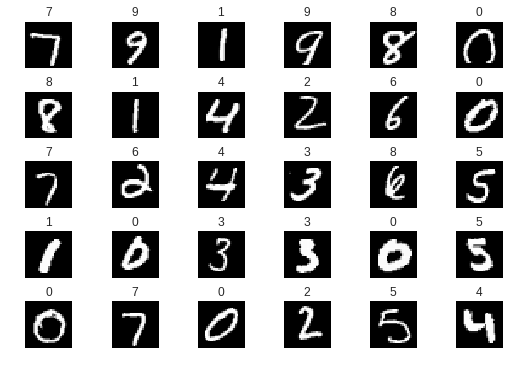

In [110]:
# Plotting 30 random examples from X_test with their predicted labels
indices = np.random.randint(0,m_test,30)
fig = plt.figure(figsize = (9,6))

for i in range (30):
    img = X_test[indices[i]].reshape(28,28)
    fig.add_subplot(5,6,i+1)    
    plt.title(y_pred[indices[i]])
    plt.imshow(img,cmap='gray')
    plt.axis("off")

plt.subplots_adjust(hspace = 0.5)    
plt.show()